# Text To SQL

## Loading and Inspecting Dataset

In [1]:
import datasets
import torch
import numpy as np

In [2]:
dataset = datasets.load_dataset('xlangai/spider')
dataset

DatasetDict({
    train: Dataset({
        features: ['db_id', 'query', 'question', 'query_toks', 'query_toks_no_value', 'question_toks'],
        num_rows: 7000
    })
    validation: Dataset({
        features: ['db_id', 'query', 'question', 'query_toks', 'query_toks_no_value', 'question_toks'],
        num_rows: 1034
    })
})

In [3]:
# random_samples_index = np.random.randint(0, len(dataset['train']), 10)
# for index in random_samples_index:
#     for key, value in dataset['train'][int(index)].items():
#         print(key)
#         print(f'\t{value}')
#     print("-"*150, end='\n\n')

In [4]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# MODEL_NAME = 'google/flan-t5-small'
MODEL_NAME = 'google/flan-t5-base'
MAX_LENGTH = 512

tokenizer = AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path=MODEL_NAME,
    use_fast=True,
    model_max_length=MAX_LENGTH
)

In [5]:
# model = AutoModelForSeq2SeqLM.from_pretrained(
#     pretrained_model_name_or_path=MODEL_NAME,
# )

# random_sample = dataset['train'][np.random.randint(0, len(dataset['train']))]
# tokenized_random_sample = tokenizer(
#     random_sample['question'],
#     return_tensors='pt'
# )
# tokenized_random_sample

In [6]:
# model.generate(
#     input_ids=tokenized_random_sample['input_ids'],
#     attention_mask=tokenized_random_sample['attention_mask'],
# ).shape

### Schemas

we need schemas as part of our input, so that the model knows what coulmns it can use

In [7]:
# schemas
SCHEMA_ADDRESS = 'richardr1126/spider-schema'
schemas = datasets.load_dataset(SCHEMA_ADDRESS)
schemas

DatasetDict({
    train: Dataset({
        features: ['db_id', 'Schema (values (type))', 'Primary Keys', 'Foreign Keys'],
        num_rows: 166
    })
})

In [8]:
# for key in schemas['train'][3].keys():
#     print(key)
#     print(f"\t{schemas['train'][0][key]}")
#     print('\n\n')

In [9]:
# creating a dic
schema_dic = {}
for index in range(0, len(schemas['train'])):
    item = schemas['train'][index]
    db_id = item['db_id']
    schema = item['Schema (values (type))']
    schema_dic[db_id] = schema

## Preprocessing

In [10]:
# dropping columns we don't need
dataset = dataset.remove_columns(
    ['query_toks', 'query_toks_no_value', 'question_toks']
)
dataset

DatasetDict({
    train: Dataset({
        features: ['db_id', 'query', 'question'],
        num_rows: 7000
    })
    validation: Dataset({
        features: ['db_id', 'query', 'question'],
        num_rows: 1034
    })
})

In [11]:
# adding schemas to the main dataset

import re

def get_cleaned_schema(schema_raw: str):
    """
    Transforms raw schema string:
    "table : col1 (type) , col2 (type) | table2 : col3 (type)"

    Into clean format:
    "table(col1, col2) | table2(col3)"
    """
    if not schema_raw:
        return ""

    # Split into separate tables by "|"
    raw_tables = schema_raw.split('|')
    cleaned_parts = []

    for raw_table in raw_tables:
        # Split Table Name from Columns
        parts = raw_table.split(':')

        if len(parts) != 2:
            continue # Skip malformed entries

        table_name = parts[0].strip()
        raw_columns = parts[1].strip()

        # Clean Columns (Remove types like "(text)", "(number)")
        clean_columns = re.sub(r'\s*\([^)]*\)', '', raw_columns)

        # Format as "table_name(col1, col2)"
        cols_list = [c.strip() for c in clean_columns.split(',')]
        formatted_cols = ", ".join(cols_list)

        cleaned_parts.append(f"{table_name}({formatted_cols})")

    return " | ".join(cleaned_parts)



def fix_question(question, db_id, prefix):
    '''
        fixes a single question
        adds prefix to the beginning
        adds the schema at the end
        the output format looks like this:
            <prefix>: <question> | Schemas: <schema-1>(column-1, column-2, ...) | <schema-2>(column-1, column-2, ...)
    '''
    schema = schema_dic[db_id]
    cleanted_schema = get_cleaned_schema(schema)
    output = prefix + ": " + question + " | " + "Schemas: " + cleanted_schema
    return output


def preprocess(batch):
    task_prefix = 'Translate English to SQL'
    query = batch['query']

    fixed_questions_list = []
    for sample_db_id, sample_question in zip(batch['db_id'], batch['question']):
        fixed_questions_list.append(fix_question(sample_question, sample_db_id, task_prefix))

    model_inputs = tokenizer(
        fixed_questions_list,
        truncation=True,
    )

    labels = tokenizer(
        text_target=query,
        truncation=True,
    )

    model_inputs["labels"] = labels["input_ids"]


    return model_inputs


In [13]:
import os

dataset['train'] = dataset['train'].map(
    preprocess,
    batched=True,
    batch_size=64,
    remove_columns=dataset['train'].column_names,
    num_proc=(os.cpu_count() // 3) + 1
)

dataset['validation'] = dataset['validation'].map(
    preprocess,
    batched=True,
    batch_size=64,
    remove_columns=dataset['validation'].column_names,
    num_proc=(os.cpu_count() // 3) + 1
)

In [14]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 7000
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1034
    })
})

In [15]:
# split validation set to test and validation

val_split = dataset['validation'].train_test_split(test_size=0.5, seed=42)
dataset['test'] = val_split['train']
dataset['validation'] = val_split['test']
del val_split
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 7000
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 517
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 517
    })
})

## Train Prep

### compute_metrics & CallBacks

In [16]:
!pip install -U evaluate -q
!pip install -U rouge_score -q

In [17]:
import evaluate
import numpy as np

rouge_metric = evaluate.load("rouge")

# def compute_metrics(eval_preds):
#     preds, labels = eval_preds

#     # If preds are logits (3D), take argmax
#     if isinstance(preds, tuple):
#         preds = preds[0]
#     if preds.ndim == 3:
#         preds = preds.argmax(-1)

#     labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
#     decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
#     decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
#     # decoded_preds = tokenizer.decode(preds, skip_special_tokens=True, batched=True)
#     # decoded_labels = tokenizer.decode(labels, skip_special_tokens=True, batched=True)

#     def normalize_sql(s):
#         return s.lower().replace(" ", "").strip()

#     # Calculate Exact Match (String Level)
#     # This is a strict proxy for the real Spider EM metric
#     exact_matches = [
#         1 if normalize_sql(p) == normalize_sql(l) else 0
#         for p, l in zip(decoded_preds, decoded_labels)
#     ]

#     result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels)

#     return {
#         "exact_match": sum(exact_matches) / len(exact_matches),
#         "rouge1": result["rouge1"],
#     }


def compute_metrics(eval_preds):
    preds, labels = eval_preds

    if isinstance(preds, tuple):
        preds = preds[0]

    preds = np.clip(preds, 0, tokenizer.vocab_size - 1)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    def normalize_sql(s):
        return s.lower().replace(" ", "").strip()

    exact_matches = [
        1 if normalize_sql(p) == normalize_sql(l) else 0
        for p, l in zip(decoded_preds, decoded_labels)
    ]

    result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels)

    return {
        "exact_match": sum(exact_matches) / len(exact_matches),
        "rouge1": result["rouge1"],
    }

In [18]:
from transformers import TrainerCallback

# class PrinterCallback(TrainerCallback):
#     def on_evaluate(self, args, state, control, metrics=None, **kwargs):
#         print("\n*** DEBUGGING GENERATION ***")

#         # 1. Grab a random sample from validation
#         # (Make sure 'tokenizer' and 'model' are available in this scope)
#         sample = dataset["validation"][0]

#         # 2. Prepare Input
#         # Note: We re-create the prompt manually to show exactly what goes in
#         schema = schema_dic[sample['db_id']]
#         clean_schema = get_cleaned_schema(schema)
#         input_text = f"Translate English to SQL: {sample['question']} | Schemas: {clean_schema}"

#         # 3. Generate
#         inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
#         with torch.no_grad():
#                 gen_tokens = model.generate(
#                     **inputs,
#                     max_length=GENERATION_MAX_LENGTH,
#                     num_beams=4,
#                     repetition_penalty=1.2,
#                     eos_token_id=tokenizer.eos_token_id,
#                     pad_token_id=tokenizer.pad_token_id
#                 )

#         decoded_pred = tokenizer.decode(gen_tokens[0], skip_special_tokens=True)

#         print(f"QUESTION: {sample['question']}")
#         print(f"PREDICTION: {decoded_pred}")
#         print(f"GOLD LABEL: {sample['query']}")
#         print("******************************\n")


# class DiagnosticCallback(TrainerCallback):
#     def on_step_begin(self, args, state, control, **kwargs):
#         if state.global_step == 1: # Run only once at the start
#             print("\n\n🔍 --- DIAGNOSTIC CHECK (Step 1) ---")

#             # Get a batch from the dataloader
#             train_dataloader = kwargs['train_dataloader']
#             batch = next(iter(train_dataloader))

#             # Move to CPU for printing
#             input_ids = batch['input_ids'][0]
#             labels = batch['labels'][0]

#             # Decode Input
#             print(f"INPUT (first 50 tokens): {tokenizer.decode(input_ids[:50], skip_special_tokens=False)}")

#             # Decode Labels (Handling -100)
#             clean_labels = [l if l != -100 else tokenizer.pad_token_id for l in labels]
#             print(f"LABEL: {tokenizer.decode(clean_labels, skip_special_tokens=False)}")

#             # CRITICAL CHECK: Check the decoder_start_token_id logic
#             # The model automatically shifts labels right to create decoder_input_ids
#             # We want to ensure it starts with <pad> (ID 0)

#             # We can't see decoder_input_ids directly here easily without running the model,
#             # but we can verify the shift manually:
#             print(f"Label IDs (Raw): {labels[:10].tolist()}")

#             # Check for bad padding in labels
#             n_pads = (labels == tokenizer.pad_token_id).sum().item()
#             print(f"Count of '0' in labels (Should be 0 if masked): {n_pads}")
#             print("--------------------------------------\n")

class PrinterCallback(TrainerCallback):
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        print("\n*** DEBUGGING GENERATION ***")

        # Hardcode a fixed example — no dataset access needed
        input_text = "Translate English to SQL: How many players are from each country? | Schemas: players(player_id, first_name, last_name, hand, birth_date, country_code) | matches(best_of, draw_size, loser_age, loser_entry, loser_hand, loser_ht, loser_id, loser_ioc, loser_name, loser_rank, loser_rank_points, loser_seed, match_num, minutes, round, score, surface, tourney_date, tourney_id, tourney_level, tourney_name, winner_age, winner_entry, winner_hand, winner_ht, winner_id, winner_ioc, winner_name, winner_rank, winner_rank_points, winner_seed, year) | rankings(ranking_date, ranking, player_id, ranking_points, tours"
        gold_label = "SELECT count(*) , country_code FROM players GROUP BY country_code"

        inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
        with torch.no_grad():
            gen_tokens = model.generate(
                **inputs,
                max_length=GENERATION_MAX_LENGTH,
                num_beams=4,
                repetition_penalty=1.2,
            )

        decoded_pred = tokenizer.decode(gen_tokens[0], skip_special_tokens=True)
        print(f"QUESTION: How many players are from each country?")
        print(f"PREDICTION: {decoded_pred}")
        print(f"GOLD LABEL: {gold_label}")
        print("******************************\n")

### Train Args

In [19]:
from transformers import TrainingArguments, Seq2SeqTrainingArguments, GenerationConfig
from pathlib import Path

SAVE_DIR = Path('./models')
TRAIN_BATCH_SIZE = 32 # BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS -> true batch size
EVAL_BATCH_SIZE = 128
LR = 0.0003
MAX_GRAD_NORM = 2
EPOCH = 10
WEIGHT_DECAY = 0.001
GRADIENT_ACCUMULATION_STEPS = 2
WARMUP_RATIO = 0.1
LABEL_SMOOTHING = 0
GENERATION_MAX_LENGTH = 128

training_args = Seq2SeqTrainingArguments(
    output_dir=SAVE_DIR,

    # --- OPTIMIZER ---
    # optim="adafactor",
    optim="adamw_torch",
    # torch_compile=True,
    # torch_compile_backend="inductor",
    # torch_compile_mode="reduce-overhead",

    # --- EVALUATION STRATEGY ---
    eval_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model='exact_match',
    greater_is_better=True,

    # --- BATCHING & OPTIMIZATION ---
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    learning_rate=LR,
    max_grad_norm=MAX_GRAD_NORM,
    num_train_epochs=EPOCH,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO,
    label_smoothing_factor=LABEL_SMOOTHING,
    lr_scheduler_type='cosine',

    # --- GENERATION ---
    predict_with_generate=True,
    generation_max_length=GENERATION_MAX_LENGTH,

    # --- LOGGING & HARDWARE ---
    logging_steps=2,            # 1 is too noisy, 10 is cleaner
    fp16=False,
    bf16=True,
    report_to='none',

    # -----
    generation_config=GenerationConfig(
        # repetition_penalty=1.2,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
        num_beams=4,
        decoder_start_token_id=tokenizer.pad_token_id,
    ),
    dataloader_num_workers=(os.cpu_count() //3 * 2),
    group_by_length=True,
)

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


In [20]:
# loading model

#!pip install peft

from transformers import AutoModelForSeq2SeqLM
from peft import LoraConfig, get_peft_model, TaskType

model = AutoModelForSeq2SeqLM.from_pretrained(
    pretrained_model_name_or_path=MODEL_NAME,
    # torch_dtype=torch.bfloat16  # Load directly in BF16
)

model.config.decoder_start_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.eos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

# lora_config = LoraConfig(
#     r=16,
#     lora_alpha=16,
#     target_modules=["q", "v", "k", "o"],
#     lora_dropout=0.0,
#     bias='none',
#     task_type=TaskType.SEQ_2_SEQ_LM,
#     init_lora_weights="gaussian",
# )

# model = get_peft_model(model, lora_config)

# # Cast base model to bf16, but keep LoRA adapters in fp32
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         param.data = param.data.to(torch.float32)  # LoRA stays fp32
#     else:
#         param.data = param.data.to(torch.bfloat16)  # base stays bf16

# # Verify
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(f"TRAINABLE: {param.dtype}")  # should be float32
#         break
# for name, param in model.named_parameters():
#     if not param.requires_grad:
#         print(f"FROZEN: {param.dtype}")  # should be bfloat16
#         break

Loading weights:   0%|          | 0/282 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


In [21]:
# data collator
from transformers import DataCollatorForSeq2Seq

data_collator_fn = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True,
    label_pad_token_id=-100, # default is -100 (-100 will be automatically ignored by PyTorch loss functions)
    pad_to_multiple_of=8,  # Optimization for TPU/GPU cores
)

# trainer
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator_fn,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    compute_metrics=compute_metrics,
    callbacks=[PrinterCallback],
)

In [22]:
# # overfit test
# from torch.optim import AdamW

# # Recreate batch
# loader = trainer.get_train_dataloader()
# batch = next(iter(loader))
# batch = {k: v.to(model.device) for k, v in batch.items()}

# # Test gradients
# model.train()
# optimizer = AdamW(model.parameters(), lr=1e-3)

# outputs = model(**batch)
# outputs.loss.backward()

# for name, param in model.named_parameters():
#     if param.requires_grad and 'lora_A' in name:
#         print(f"lora_A grad norm={param.grad.norm().item():.6f}: {name}")
#         break
# for name, param in model.named_parameters():
#     if param.requires_grad and 'lora_B' in name:
#         print(f"lora_B grad norm={param.grad.norm().item():.6f}: {name}")
#         break

In [23]:
# optimizer = AdamW(model.parameters(), lr=1e-3)

# for step in range(100):
#     optimizer.zero_grad()
#     outputs = model(**batch)
#     loss = outputs.loss
#     loss.backward()
#     optimizer.step()
#     if step % 10 == 0:
#         print(f"Step {step}: loss={loss.item():.4f}")

## Train

In [24]:
results = trainer.train()

Epoch,Training Loss,Validation Loss,Exact Match,Rouge1
1,8.114592,4.685050,0.001934,0.201998
2,4.246203,2.651095,0.013540,0.403109
3,2.745584,1.776871,0.015474,0.459139
4,2.068074,1.530793,0.027079,0.510017
5,1.619613,1.343621,0.040619,0.568417
6,1.401009,1.216925,0.048356,0.607367
7,1.229498,1.218488,0.054159,0.626727
8,1.279480,1.200218,0.058027,0.646200
9,1.191439,1.225483,0.056093,0.639944
10,1.144081,1.133277,0.056093,0.643872



*** DEBUGGING GENERATION ***
QUESTION: How many players are from each country?
PREDICTION: SELECT count(*) FROM players
GOLD LABEL: SELECT count(*) , country_code FROM players GROUP BY country_code
******************************



Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


*** DEBUGGING GENERATION ***
QUESTION: How many players are from each country?
PREDICTION: SELECT count(*) FROM player WHERE country_code = 'Fast'
GOLD LABEL: SELECT count(*) , country_code FROM players GROUP BY country_code
******************************



Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


*** DEBUGGING GENERATION ***
QUESTION: How many players are from each country?
PREDICTION: SELECT count(*) , country_code FROM player GROUP BY country_code
GOLD LABEL: SELECT count(*) , country_code FROM players GROUP BY country_code
******************************



Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


*** DEBUGGING GENERATION ***
QUESTION: How many players are from each country?
PREDICTION: SELECT country_code , count(*) FROM player WHERE country_code = 'Fosser' GROUP BY country_code
GOLD LABEL: SELECT count(*) , country_code FROM players GROUP BY country_code
******************************



Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


*** DEBUGGING GENERATION ***
QUESTION: How many players are from each country?
PREDICTION: SELECT country_code , count(*) FROM player GROUP BY country_code
GOLD LABEL: SELECT count(*) , country_code FROM players GROUP BY country_code
******************************



Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


*** DEBUGGING GENERATION ***
QUESTION: How many players are from each country?
PREDICTION: SELECT count(*) , country_code FROM player GROUP BY country_code
GOLD LABEL: SELECT count(*) , country_code FROM players GROUP BY country_code
******************************



Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


*** DEBUGGING GENERATION ***
QUESTION: How many players are from each country?
PREDICTION: SELECT country_code , count(*) FROM player GROUP BY country_code
GOLD LABEL: SELECT count(*) , country_code FROM players GROUP BY country_code
******************************



Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


*** DEBUGGING GENERATION ***
QUESTION: How many players are from each country?
PREDICTION: SELECT country_code , count(*) FROM player GROUP BY country_code
GOLD LABEL: SELECT count(*) , country_code FROM players GROUP BY country_code
******************************



Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


*** DEBUGGING GENERATION ***
QUESTION: How many players are from each country?
PREDICTION: SELECT country_code , count(*) FROM player GROUP BY country_code
GOLD LABEL: SELECT count(*) , country_code FROM players GROUP BY country_code
******************************



Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


*** DEBUGGING GENERATION ***
QUESTION: How many players are from each country?
PREDICTION: SELECT country_code , count(*) FROM player GROUP BY country_code
GOLD LABEL: SELECT count(*) , country_code FROM players GROUP BY country_code
******************************



Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


In [37]:
random_sample_index = np.random.randint(0, len(dataset['validation']), 1)
random_sample = dataset["validation"][random_sample_index]

input_text = tokenizer.decode(random_sample['input_ids'], skip_special_tokens=True)
query = tokenizer.decode(random_sample['labels'], skip_special_tokens=True)
labels = tokenizer.decode(random_sample['input_ids'], skip_special_tokens=True)

# Tokenize & Generate
inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
output_tokens = model.generate(**inputs, max_length=128)
decoded_output = tokenizer.decode(output_tokens[0], skip_special_tokens=True)

print(f"QUESTION: {input_text[0]}")
print(f"PREDICTION: {decoded_output}")
print(f"REAL LABEL: {query[0]}")

QUESTION: Translate English to SQL: What is the horsepower of the car with the greatest accelerate? | Schemas: continents(ContId, Continent) | countries(CountryId, CountryName, Continent) | car_makers(Id, Maker, FullName, Country) | model_list(ModelId, Maker, Model) | car_names(MakeId, Model, Make) | cars_data(Id, MPG, Cylinders, Edispl, Horsepower, Weight, Accelerate, Year)
PREDICTION: SELECT HAVING COUNT(*) = (SELECT count(*) FROM drivers_data ORDER BY acceleratoreate DESC LIMIT 1)
REAL LABEL: SELECT T1.horsepower FROM CARS_DATA AS T1 ORDER BY T1.accelerate DESC LIMIT 1;


___

In [39]:
from huggingface_hub import login

login()  # will prompt for your HF token

model.push_to_hub("artmiss/flan-t5-base-spider-text2sql")
tokenizer.push_to_hub("artmiss/flan-t5-base-spider-text2sql")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...j_4n5n9/model.safetensors:   0%|          |  553kB /  990MB            

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/artmiss/flan-t5-base-spider-text2sql/commit/fb034806db4a339bdafe1507e2f4130538fcf2f5', commit_message='Upload tokenizer', commit_description='', oid='fb034806db4a339bdafe1507e2f4130538fcf2f5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/artmiss/flan-t5-base-spider-text2sql', endpoint='https://huggingface.co', repo_type='model', repo_id='artmiss/flan-t5-base-spider-text2sql'), pr_revision=None, pr_num=None)

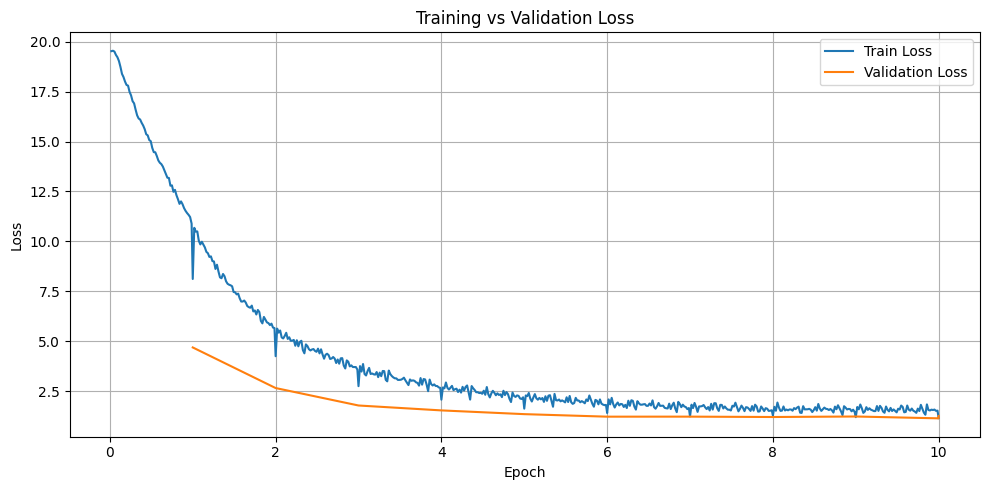

In [43]:
import matplotlib.pyplot as plt

# Extract from trainer logs
log_history = trainer.state.log_history

train_losses = [(x['epoch'], x['loss']) for x in log_history if 'loss' in x and 'eval_loss' not in x]
eval_losses = [(x['epoch'], x['eval_loss']) for x in log_history if 'eval_loss' in x]

train_epochs, train_loss_vals = zip(*train_losses)
eval_epochs, eval_loss_vals = zip(*eval_losses)

plt.figure(figsize=(10, 5))
plt.plot(train_epochs, train_loss_vals, label='Train Loss')
plt.plot(eval_epochs, eval_loss_vals, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('loss_curve.png', dpi=150)
plt.show()

In [41]:
test_results = trainer.evaluate(dataset['test'])
print(f"Test Loss: {test_results['eval_loss']:.4f}")
print(f"Test Exact Match: {test_results['eval_exact_match']:.4f}")


*** DEBUGGING GENERATION ***
QUESTION: How many players are from each country?
PREDICTION: SELECT country_code , count(*) FROM player GROUP BY country_code
GOLD LABEL: SELECT count(*) , country_code FROM players GROUP BY country_code
******************************

Test Loss: 1.2527
Test Exact Match: 0.0638


In [79]:
import random

def test_samples(model, tokenizer, dataset, schema_dic, n=5, seed=42):
    random.seed(seed)
    samples = random.sample(range(len(dataset['test'])), n)

    model.eval()

    for i, idx in enumerate(samples):
        sample = dataset['test'][idx]

        # Decode input to get the original question
        input_ids = sample['input_ids']
        input_text = tokenizer.decode(input_ids, skip_special_tokens=True)

        # Decode gold label
        labels = [l if l != -100 else tokenizer.pad_token_id for l in sample['labels']]
        gold_sql = tokenizer.decode(labels, skip_special_tokens=True)

        # Generate prediction
        inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
        with torch.no_grad():
            gen_tokens = model.generate(
                **inputs,
                max_length=GENERATION_MAX_LENGTH,
                num_beams=4,
            )
        prediction = tokenizer.decode(gen_tokens[0], skip_special_tokens=True)

        # Simple exact match
        def normalize(s):
            return s.lower().replace(" ", "").strip()

        match = "✅" if normalize(prediction) == normalize(gold_sql) else "❌"

        print(f"--- Sample {i+1} {match} ---")
        print(f"INPUT:      {input_text[:120]}...")
        print(f"PREDICTION: {prediction}")
        print(f"GOLD:       {gold_sql}")
        print()

test_samples(model, tokenizer, dataset, schema_dic, n=5)

--- Sample 1 ❌ ---
INPUT:      Translate English to SQL: What are the ids, version numbers, and type codes for each template? | Schemas: Ref_Template_T...
PREDICTION: SELECT project_id , product_number , project_type_code FROM Projects
GOLD:       SELECT template_id , version_number , template_type_code FROM Templates

--- Sample 2 ❌ ---
INPUT:      Translate English to SQL: What is the first name, country code, and birth date of the player with the most winner rank p...
PREDICTION: SELECT T1.first_name , T1.country_code , T1.birth_date FROM player AS T1 JOIN rank AS T2 ON T1.player_id = T2.player_id GROUP BY T1.player_id ORDER BY count(*) DESC LIMIT 1
GOLD:       SELECT T1.first_name , T1.country_code , T1.birth_date FROM players AS T1 JOIN matches AS T2 ON T1.player_id = T2.winner_id ORDER BY T2.winner_rank_points DESC LIMIT 1

--- Sample 3 ❌ ---
INPUT:      Translate English to SQL: Which airlines have departures from CVO but not from APG airports? | Schemas: airlines(uid, Ai...
PRE

test on test set

- `label_pad_token_id=-100` in data collator and overall, modifying this padding token to -100. why can't we just set the CrossEntropyLoss(ignore_index=0) ?
note that we have 2 padding, one for the input_ids, and one for labels, and they are different apperantly